In [1]:
import simdna
import simdna.synthetic as synthetic
import avutils
from avutils import util
reload(util)
import numpy as np
import momma_dragonn
reload(momma_dragonn)
import keras

In [2]:
def generate_sequences_set(seq_length, num_seqs, motif_names):
    loadedMotifs = synthetic.LoadedEncodeMotifs(simdna.ENCODE_MOTIFS_PATH, pseudocountProb=0.001)
    embedInBackground = synthetic.EmbedInABackground(
        backgroundGenerator=synthetic.ZeroOrderBackgroundGenerator(seqLength=seq_length)
        , embedders=[
            synthetic.RepeatedEmbedder(
            synthetic.SubstringEmbedder(
                #synthetic.ReverseComplementWrapper(
                substringGenerator=synthetic.PwmSamplerFromLoadedMotifs(
                    loadedMotifs=loadedMotifs,motifName=motifName)
                #),
                ,positionGenerator=synthetic.UniformPositionGenerator()),
            quantityGenerator=
                synthetic.ZeroInflater(
                    #synthetic.MinMaxWrapper(synthetic.PoissonQuantityGenerator(1),theMax=1, theMin=0),
                    synthetic.FixedQuantityGenerator(1),
                    zeroProb=0.9)
            )
            for motifName in motif_names
        ]
    )
    sequenceSetGenerator = synthetic.GenerateSequenceNTimes(embedInBackground, num_seqs)
    return sequenceSetGenerator

def one_hot_encode_sequences_set(sequence_set_generator):
    one_hot_encoded_sequences = []
    for sequence in sequence_set_generator.generateSequences():
        one_hot_encoded_sequences.append(avutils.util.seq_to_2d_image(sequence.seq))
    return np.array(one_hot_encoded_sequences)

seq_length=45


motif_names = ["CTCF_known1"]#, "IRF_known1", "GATA_disc1"]

num_train_samples = 20000

one_hot_data_train_pos, one_hot_data_train_neg =\
 [one_hot_encode_sequences_set(generate_sequences_set(seq_length=seq_length, num_seqs=num_train_samples, motif_names=names))
  for names in [motif_names, []]]
one_hot_data_train_inputs = one_hot_data_train_pos #np.concatenate([one_hot_data_train_pos, one_hot_data_train_neg], axis=0)
one_hot_data_train_labels = one_hot_data_train_pos #np.concatenate([one_hot_data_train_pos, -one_hot_data_train_neg], axis=0)
_ = util.shuffle_arrays([one_hot_data_train_inputs, one_hot_data_train_labels], copy_on_shuffle=True)


In [3]:
reload(util)
one_hot_data_valid_pos, one_hot_data_valid_neg =\
 [one_hot_encode_sequences_set(generate_sequences_set(seq_length=seq_length, num_seqs=1000, motif_names=names))
  for names in [motif_names, []]]
one_hot_data_valid_inputs = one_hot_data_valid_pos #np.concatenate([one_hot_data_valid_pos, one_hot_data_valid_neg], axis=0)
one_hot_data_valid_labels = one_hot_data_valid_pos #np.concatenate([one_hot_data_valid_pos, -one_hot_data_valid_neg], axis=0)
_ = util.shuffle_arrays([one_hot_data_valid_inputs, one_hot_data_valid_labels], copy_on_shuffle=True)

In [14]:
import keras
reload(keras)
import keras.objectives
reload(keras.objectives)
from keras import backend
reload(backend)
import keras.layers.convolutional
reload(keras.layers.convolutional)
import momma_dragonn
reload(momma_dragonn)
reload(momma_dragonn.end_of_epoch_callbacks)
reload(momma_dragonn.data_loaders)
reload(momma_dragonn.model_evaluators)
reload(momma_dragonn.model_trainers.keras_model_trainer)
reload(momma_dragonn.data_loaders.core)

filters_per_motif=1
def model_creator_func(nb_filter):
    filter_width=20
    maxpool_filter_width=seq_length-(filter_width-1) #pool over entire region for now
    #maxpool_filter_width=20
    
    from keras.models import Graph
    graph = Graph() 
    graph.add_input(name="sequence", input_shape=(1,4,seq_length))
    #add convolutional layer
    graph.add_node(
        keras.layers.convolutional.Convolution2D(nb_filter=nb_filter, nb_row=4, nb_col=filter_width, activation="relu"),
        name="conv", input="sequence")
    #add maxpool filter layer
    graph.add_node(
        #keras.layers.convolutional.MaxPoolFilter2D_CenteredPool(pool_size=(1,maxpool_filter_width)),
        keras.layers.convolutional.MaxPoolFilter2D_NonOverlapStrides(pool_size=(1,maxpool_filter_width)),
        name="filt", input="conv")
    #add a padding layer so deconv will be the right size
    graph.add_node(
        keras.layers.convolutional.ZeroPadding2D(padding=(0,filter_width-1)),
        name="padding", input="filt")
    #add a deconv layer to reconstruct the input
    graph.add_node(
        keras.layers.convolutional.Convolution2D(
            nb_filter=4, nb_row=1, nb_col=filter_width,
            W_constraint=keras.constraints.MaxNorm(m=10)),
        name="deconv", input="padding")
    #transpose to make the deconv axis the row axis
    graph.add_node(
        keras.layers.convolutional.ExchangeChannelsAndRows(),
        name="swapaxes", input="deconv")
    #softmax across rows
    graph.add_node(
        keras.layers.convolutional.SoftmaxAcrossRows(),
        name="output_softmax", input="swapaxes")
    #designate output node
    graph.add_output(name="output", input="output_softmax")
    #compile
    graph.compile(
        optimizer=keras.optimizers.Adam(),
        loss={"output": "one_hot_rows_categorical_cross_entropy"}
    )
    return graph

#model creator
model_creator = momma_dragonn.model_creators.flexible_keras.KerasModelFromFunc(
    func=lambda: model_creator_func(filters_per_motif*len(motif_names)),
    model_wrapper_class=momma_dragonn.model_wrappers.keras_model_wrappers.KerasGraphModelWrapper)    

#data loaders
train_data_loader = momma_dragonn.data_loaders.core.BatchDataLoader_XYDictAPI(
                        X={'sequence': one_hot_data_train_inputs}, Y={'output': one_hot_data_train_labels},
                        weight={}, batch_size=200, num_to_load_for_eval=num_train_samples, bundle_x_and_y_in_generator=True)
valid_data_loader = momma_dragonn.data_loaders.core.AtOnceDataLoader_XYDictAPI(
                        X={'sequence': one_hot_data_valid_inputs}, Y={'output': one_hot_data_valid_labels})
#model evaluator
model_evaluator = momma_dragonn.model_evaluators.GraphAccuracyStats(
    key_metric="onehot_rows_crossent", all_metrics=["onehot_rows_crossent"])

#stopping criterion
stopping_criterion_config = {"class": "EarlyStopping", "kwargs": {"max_epochs": 300, "epochs_to_wait": 3}}

#callbacks
end_of_epoch_callbacks = []#momma_dragonn.end_of_epoch_callbacks.PrintPerfAfterEpoch(print_trend=True)]

#trainer
trainer = momma_dragonn.model_trainers.keras_model_trainer.KerasFitGeneratorModelTrainer(
    samples_per_epoch=num_train_samples, stopping_criterion_config=stopping_criterion_config)

#train model
model_wrapper, performance_history, training_metadata = trainer.train(model_wrapper=model_creator.get_model_wrapper(),
                                                          model_evaluator=model_evaluator,
                                                          valid_data_loader=valid_data_loader,
                                                          other_data_loaders={'train': train_data_loader},
                                                          end_of_epoch_callbacks=end_of_epoch_callbacks)

('Input modes', ['sequence'])
('Output modes', ['output'])
Loading momma_dragonn.stopping_criteria.EarlyStopping
Loading validation data into memory
Loaded
Epoch 1/1
20000/20000 [==============================] - 3s - loss: 1.3801 - val_loss: 1.3673
Epoch 1/1
20000/20000 [==============================] - 3s - loss: 1.3524 - val_loss: 1.3415
Epoch 1/1
20000/20000 [==============================] - 3s - loss: 1.3379 - val_loss: 1.3362
Epoch 1/1
20000/20000 [==============================] - 3s - loss: 1.3354 - val_loss: 1.3352
Epoch 1/1
20000/20000 [==============================] - 3s - loss: 1.3346 - val_loss: 1.3346
Epoch 1/1
20000/20000 [==============================] - 3s - loss: 1.3337 - val_loss: 1.3338
Epoch 1/1
20000/20000 [==============================] - 3s - loss: 1.3322 - val_loss: 1.3326
Epoch 1/1
20000/20000 [==============================] - 3s - loss: 1.3299 - val_loss: 1.3309
Epoch 1/1
20000/20000 [==============================] - 3s - loss: 1.3269 - val_loss: 1.328

Using Theano backend.


In [15]:
file_prefix="solofilter_relu_10pcCTCF_45bp_fullmaxpool"

In [16]:
model_wrapper.create_files_to_save(directory=".", prefix=file_prefix)
model = model_wrapper.model

In [6]:
from keras.models import model_from_yaml                                    
model = model_from_yaml(open(file_prefix+"_modelYaml.yaml").read())
model.load_weights(file_prefix+"_modelWeights.h5")

In [17]:
%matplotlib inline
#import deepLIFT stuff
import os, sys
import numpy as np
scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to enhancer_prediction_code");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/");
import criticalSubsetIdentification as csi
import deepLIFTutils
reload(deepLIFTutils)

<module 'deepLIFTutils' from '/Users/avantishrikumar/Research/Enhancer_Prediction/enhancer_prediction_code/featureSelector/deepLIFFT/deepLIFTutils.pyc'>

In [18]:
deconv_weights, deconv_biases = model.nodes['deconv'].get_weights()
weights = np.transpose(deconv_weights,(1,2,0,3))
weights = weights[:,:,::-1,::-1] #flip the acgt to mimic actual conv weights
print(weights.shape)

(1, 1, 4, 20)


In [19]:
np.sum(np.max(weights,axis=-2)-np.min(weights,axis=-2),axis=-1)

array([[ 18.34969902]], dtype=float32)

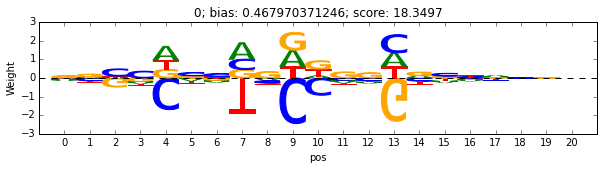

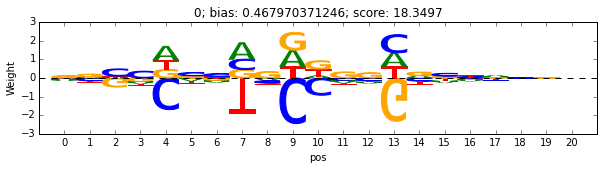

In [20]:
filterScores = np.sum((np.max(weights,axis=-2)-np.min(weights,axis=-2)),axis=-1)[:,0]
sortedFilters = sorted(enumerate(filterScores), key=lambda x: -x[1])
deepLIFTutils.plotPositiveAndNegativeOutlierFilters(sortedFilters=sortedFilters
                                                    , numPositiveOutliers=len(weights)
                                                    , numNegativeOutliers=1
                                                    , weights=weights
                                                    , biases=np.zeros(len(weights))
                                                    , printBias=False
                                                    , figSize=(10,2))

In [21]:
weights, biases = model.nodes['conv'].get_weights()

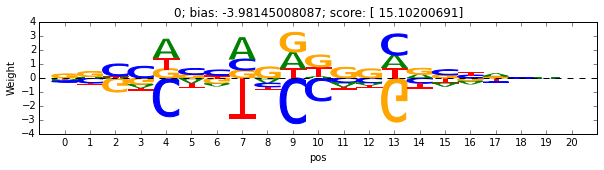

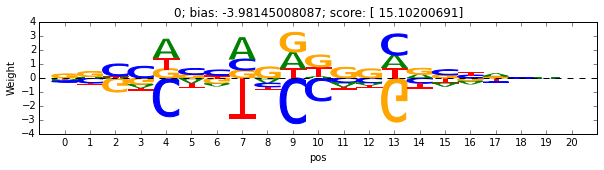

In [22]:
filterScores = np.sum((np.max(weights,axis=-1)-np.min(weights,axis=-1)),axis=-1)
sortedFilters = sorted(enumerate(filterScores), key=lambda x: -x[1])
deepLIFTutils.plotPositiveAndNegativeOutlierFilters(sortedFilters=sortedFilters
                                                    , numPositiveOutliers=len(weights)
                                                    , numNegativeOutliers=1
                                                    , weights=weights
                                                    , biases=np.zeros(len(weights))
                                                    , printBias=False
                                                    , figSize=(10,2))